# MNIST classification with PyTorch, comparing federated model vs model trained locally

**Overview of the tutorial**: 

In this tutorial, we are going to compare Federated models created through Fed-BioMed framework and a model trained locally (through `LocalJob` function provided by Fed-BioMed). To this end, we will re-use the model trained in the first [PyTorch tutorial: MNIST basic Example](/tutorials/pytorch/01_PyTorch_MNIST_Single_Node_Tutorial) and compare it to a model trained locally. Thus it is recommanded to run this first tutorial before this one.

At the end of this tutorial, you will learn:

* how to train a model in Pytorch designed for Fed-BioMed locally 
* how to evaluate both models


**HINT** : to reload the notebook,  please click on the following button:

`Kernel` -> `Restart and clear Output`

    
<img src="/assets/img/sketch_reload_notebook.bmp" width="50%">

## 0. Clean your environments

Before executing notebook and starting nodes, it is safer to remove all configuration scripts automatically generated by Fed-BioMed. To do so, enter the following in a terminal:

```shell
source ${FEDBIOMED_DIR}/scripts/fedbiomed_environment clean
```

**Note:** `${FEDBIOMED_DIR}` is a path relative to based directory of the cloned Fed-BioMed repository. You can set it by running command `export FEDBIOMED_DIR=/path/to/fedbiomed`. This is not required for Fed-BioMed to work but enables you to run the tutorials more easily. 

## 1. Configuring Nodes 

In this tutorial, you will learn how to train your model with a single Fed-BioMed node. Thus, we need to configure a node and add MNIST dataset to it. Node configuration steps require `fedbiomed-node` conda environment. Please make sure that you have the necessary conda environment: this is explained in the [installation tutorial](/tutorials/installation/0-basic-software-installation). You can check your environment by running the following command. 

```
$ conda env list
```
If you have all Fed-BioMed environments you are ready to go for the node configuration steps. 

Please open a terminal, `cd` to the base directory of the cloned fedbiomed project and follow the steps below.    

* **Configuration Steps:**
    * Run `${FEDBIOMED_DIR}/scripts/fedbiomed_node run node add` in the terminal
    * It will ask you to select the data type that you want to add. The second option (which is the default) has been configured to add the MNIST dataset. Please type `2` and continue. 
    * Please use default tags which are `#MNIST` and `#dataset`.
    * For the next step, please select the directory that you want to download the MNIST dataset.
    * After the download is completed you will see the details of the MNIST dataset on the screen.
 
Please run the command below in the same terminal to make sure the MNIST dataset is successfully added to the node.  

## 2. Running Tutorial: Basic PyTorch on MNIST dataset

In this notebook tutorial, we are going to re-use the Convolution neural network model defined in this first tutorial. Hence, this notebook will be considered to be the continuation of the first tutorial. For more details; please refer to the forementioned tutorial material.

## 3. Defining a Fed-BioMed Model on MNIST dataset

In [1]:
from fedbiomed.researcher.environ import environ
import tempfile
import os

tmp_dir_model = tempfile.TemporaryDirectory(dir=environ['TMP_DIR']+os.sep)
model_file = os.path.join(tmp_dir_model.name, 'class_model_mnist.py')

In [ ]:
%%writefile "$model_file"

import torch
import torch.nn as nn
from fedbiomed.common.torchnn import TorchTrainingPlan
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Here we define the model to be used. 
# You can use any class name (here 'Net')
class MyTrainingPlan(TorchTrainingPlan):
    def __init__(self, model_args: dict = {}):
        self.setting_random_seed()
        super(MyTrainingPlan, self).__init__(model_args)
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        
        
        
        # Here we define the custom dependencies that will be needed by our custom Dataloader
        # In this case, we need the torch DataLoader classes
        # Since we will train on MNIST, we need datasets and transform from torchvision
        deps = ["from torchvision import datasets, transforms",
               "from torch.utils.data import DataLoader"]
        self.add_dependency(deps)
        
        
    def setting_random_seed(wk_id: int=1):
        # defining random seed
        import random
        import numpy as np
        
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:
            random_seed = 1234
        else:
            random_seed = worker_info.seed
        random.seed(random_seed)
        torch.manual_seed(random_seed)
        #torch.cuda.manual_seed(random_seed)
        np.random.seed(random_seed)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

    def training_data(self, batch_size = 48):
        # Custom torch Dataloader for MNIST data
        transform = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])
        dataset1 = datasets.MNIST(self.dataset_path, train=True, download=False, transform=transform)
        train_kwargs = {'batch_size': batch_size,
                        'shuffle': True,
                        'worker_init_fn': self.setting_random_seed
                       }
        data_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
        return data_loader
    
    def training_step(self, data, target):
        output = self.forward(data)
        loss   = torch.nn.functional.nll_loss(output, target)
        return loss
    


In [3]:
model_args = {}

training_args = {
    'batch_size': 48, 
    'lr': 1e-3, 
    'epochs': 1, 
    'dry_run': False,  
    'batch_maxnum': 100 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

tags =  ['#MNIST', '#dataset']
rounds = 1

## 4. Training the Model in a Federated setting

We will reproduce the same steps as in [Tutorial: Basic PyTorch on MNIST dataset](/tutorials/pytorch/01_PyTorch_MNIST_Single_Node_Tutorial). Remote model will be trained on a single Node.


In [ ]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage



remote_experiment = Experiment(tags=tags,
                               model_path=model_file,
                               model_args=model_args,
                               model_class='MyTrainingPlan',
                               training_args=training_args,
                               round_limit=rounds,
                               aggregator=FedAverage(),
                               node_selection_strategy=None)

In [ ]:
remote_experiment.run()

## 5. Training FedBiomed model locally

In this section, we are going to re-use the defined model and train it locally using `localJob` function provide by Fed-BioMed. This function is only used for comparing model locally; on researcher side.

To use `localJob` function could prove useful and wise for testing a federated model on your own system, and checking if it is working correctly before deploying it on nodes.

First you need to create a folder containing your dataset on your system (ie on `environ['TMP_DIR']/local_mnist.tmp` folder).

In [ ]:
import os
from torchvision import datasets, transforms
from fedbiomed.researcher.environ import environ

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

datasets.MNIST(root = os.path.join(environ['TMP_DIR'], 'local_mnist.tmp'),
               download = True,
               train = True,
               transform = transform)

An object `localJob` has to be created: it mimics the functionalities of the class `Job` to run the model on the input local dataset

In [7]:
# The class local job mimics the class job used in the experiment
from fedbiomed.researcher.job import localJob

# local train on same amount of data as federated with 1 node
training_args['epochs'] *= rounds

local_job = localJob( dataset_path = os.path.join(environ['TMP_DIR'], 'local_mnist.tmp'),
          model_class='MyTrainingPlan',
          model_path=model_file,
          training_args=training_args)

Run the localJob

In [ ]:
local_job.start_training()

Retrieve the local models parameters

In [9]:
local_model = local_job.model_instance

## 6. Comparison between Federated model and model trained locally

Let's try to compare our local model against the Federated model, on the MNIST testing dataset

In [10]:
import torch
import torch.nn.functional as F
import pandas as pd

def testing_accuracy(model, data_loader):
    model.eval()
    test_loss = 0
    correct = 0
    device = 'cpu'

    correct = 0
    y_pred = []
    y_actu = []
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            y_pred.extend(torch.flatten(pred).tolist()) 
            y_actu.extend(target.tolist())

        y_pred = pd.Series(y_pred, name='Actual')
        y_actu = pd.Series(y_actu, name='Predicted')
        cm = pd.crosstab(y_actu, y_pred)
        #correct = sum([cm.iloc[i,i] for i in range(len(cm))])

    test_loss /= len(data_loader.dataset)
    accuracy = 100* correct/len(data_loader.dataset)

    return(test_loss, accuracy, cm)

In [11]:
from torchvision import datasets, transforms

test_set = datasets.MNIST(root = os.path.join(environ['TMP_DIR'], 'local_mnist.tmp'),
                          download = True,
                          train = False,
                          transform = transform)


test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=64,
                                          shuffle=False)



Load remote model

In [ ]:
remote_model = remote_experiment.model_instance()
remote_model.load_state_dict(remote_experiment.aggregated_params()[rounds - 1]['params'])

Compute errors for both remote (federated) and local model

In [13]:
# remote accuracy and error computation
remote_loss, remote_acc, remote_conf_matrix = testing_accuracy(remote_model, test_loader)


# local accuracy and error computation
local_loss, local_acc, local_conf_matrix = testing_accuracy(local_model, test_loader)

In [14]:
print('\nAccuracy local training: {:.4f}, \nAccuracy federated training:  {:.4f}\nDifference: {:.4f}'.format(
             local_acc, remote_acc, abs(local_acc - remote_acc)))

print('\nError local training: {:.4f}, \nError federated training:  {:.4f}\nDifference: {:.4f}'.format(
             local_loss, remote_loss, abs(local_loss - remote_loss)))


Accuracy local training: 94.7600, 
Accuracy federated training:  94.7600
Difference: 0.0000

Error local training: 0.1711, 
Error federated training:  0.1711
Difference: 0.0000


### Plotting Confusion Matrix of both remote and local Models

In [ ]:
!pip install matplotlib

In [15]:
def plot_confusion_matrix(fig, ax, conf_matrix, title, xlabel, ylabel, n_image=0):
    
    im = ax[n_image].imshow(conf_matrix)

    ax[n_image].set_xticks(np.arange(10))
    ax[n_image].set_yticks(np.arange(10))

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            text = ax[n_image].text(j, i, conf_matrix[i, j],
                           ha="center", va="center", color="w")

    ax[n_image].set_xlabel(xlabel)
    ax[n_image].set_ylabel(ylabel)
    ax[n_image].set_title(title)

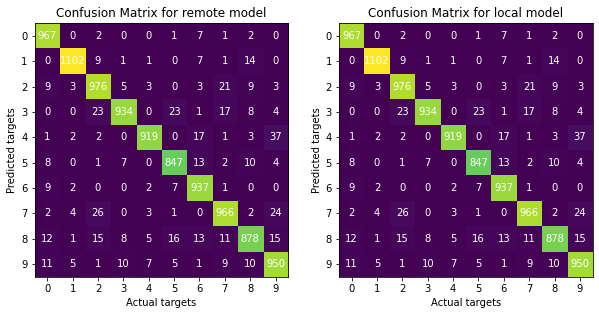

In [16]:
import numpy as np
import matplotlib.pyplot as plt



fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(10,5)) 
plot_confusion_matrix(fig, axs, remote_conf_matrix.to_numpy(),
                     'Confusion Matrix for remote model',
                     'Actual targets',
                      'Predicted targets', n_image=0)


plot_confusion_matrix(fig, axs, local_conf_matrix.to_numpy(),
                     'Confusion Matrix for local model',
                     'Actual targets',
                      'Predicted targets', n_image=1)


## Congrats! 

Now you know how to train a Fed-BioMed model designed with Pytorch framework locally.

Check out other tutorials and documentation to learn more about Fed-BioMed Federated Learning Framework
